### Seleção de casos

### Caso 1 - Forrest Fire (Portugal) prediction using SVR, Random Forest, and Deep NN

Este trabalho compara 4 métodos distintos de IA para predição de incêncidos em florestas utilizando dados metereológicos:
 - a) support vector regression
 - b) decision tree
 - c) random forest
 - d) 3-layer dense neural network

Este é um problema de regressão muito difícil e com problemas de outliers.
    - Este conjunto de dados é público
    - P. Cortez and A. Morais. *A Data Mining Approach to Predict Forest Fires using Meteorological Data.* In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9.

    - Acesso em 24.nov.22: http://www.dsi.uminho.pt/~pcortez/fires.pdf
    - Acesso em 24.nov.22: [Cortez and Morais, 2007].
    
Metadados:
- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: "jan" to "dec"
- day - day of the week: "mon" to "sun"
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3
- DC - DC index from the FWI system: 7.9 to 860.6
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84

http://www.dsi.uminho.pt/~pcortez/fires.pdf

In [1]:
#Bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

### pip install --upgrade scikit-learn
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Leitura do dataset
df = pd.read_csv('forestfires.csv')
# Transformação da dimensão 'área' pelo seu logaritmo (depois de somar 1 para evitar zeros)
df['Log-area']=np.log10(df['area']+1)
# Codificação de rótulos para dimensões categóricas (dia e mês)
# Codificação MES
enc = LabelEncoder()
enc.fit(df['month'])
enc.classes_
df['month_encoded']=enc.transform(df['month'])
# Codificação DIA
enc.fit(df['day'])
enc.classes_
df['day_encoded']=enc.transform(df['day'])
#df.head(5)

In [66]:
# Estatísticas descritivas
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Log-area,month_encoded,day_encoded
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.482512,5.758221,2.736944
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.607333,4.373275,1.925061
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.181844,6.000000,3.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,0.879096,11.000000,4.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,3.038159,11.000000,6.000000


In [5]:
# Representar graficamente, através de gráficos de dispersão e distribuições características
# numéricas para ver como elas podem afetas a dimensõa "área"
# for i in df.describe().columns[:-2]:
#    df.plot.scatter(i,'Log-area',grid=True)

In [6]:
# Plotagem de boxplots de como as características categóricas (mês e dia) afetam o resultado
# df.boxplot(column='Log-area',by='day')

In [7]:
# df.boxplot(column='Log-area',by='month')

In [8]:
# configuração do tamanho do conjunto-teste
test_size=0.4

In [9]:
# segmentação teste-treino
X_data=df.drop(['area','Log-area','month','day'],axis=1)
y_data=df['Log-area']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

In [10]:
y_train=y_train.values.reshape(y_train.size,1)
#y_train=y_train.reshape(y_train.size,1)

#### Parametros de comparação entre os métodos

#### 1 - Regression Error Characteristic (REC) estimation
##### Estimativa da Característica de Erro de Regressão (REC)
- As curvas ROC (Receiver Operating Characteristic) fornecem uma ferramenta poderosa para visualizar e comparar os resultados da classificação.
- As curvas de Característica de Erro de Regressão (REC) generalizam as curvas ROC para regressão. As curvas REC plotam a tolerância ao erro no versus a porcentagem de pontos prevista dentro da tolerância no. A curva resultante estima a função de distribuição cumulativa do erro. A curva REC apresenta visualmente estatísticas comumente usadas.
- A área sobre a curva (AOC) é uma estimativa tendenciosa do erro esperado. O valor pode ser estimado usando a razão entre o COA para um determinado modelo e o COA para o modelo nulo.
- Os usuários podem avaliar rapidamente os méritos relativos de muitas funções de regressão examinando a posição relativa de suas curvas REC.
- A forma da curva revela informações adicionais que podem ser usadas para orientar a modelagem.

In [11]:
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [12]:
# Definir o limite máximo de tolerância para o eixo x da curva REC - Para este problema, isso 
# representa o valor absoluto do erro na previsão do resultado, ou seja, a área queimada
tol_max=20

##### Seleção de Parametros - uso da biblioteca GridSearchCV

    - O Scikit-learn tem a funcionalidade de tentar diversas combinações e ver o que funciona melhor, embutido com o GridSearchCV! O CV significa validação cruzada.
    - O GridSearchCV leva um dicionário que descreve os parâmetros que devem ser tentados e um modelo para treino.
    - A grade de parâmetros é definida como um dicionário, onde as chaves são os parâmetros e os valores são as configurações a serem testadas.

### Método 1 - Support Vector Regressor (SVR) - Regressor vetorial de suporte (SVR)


In [13]:
scaler = StandardScaler()

In [14]:
# Parameter grid for the Grid Search
param_grid = {'C': [0.01,0.1,1, 10], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [15]:
grid_SVR = GridSearchCV(SVR(),param_grid,refit=True,verbose=0,cv=5)
grid_SVR.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'epsilon': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [16]:
print("Best parameters obtained by Grid Search:",grid_SVR.best_params_)

Best parameters obtained by Grid Search: {'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}


In [17]:
#plt.xlabel("Actual area burned")
#plt.ylabel("Error")
#plt.grid(True)
#plt.scatter(10**(y_test),10**(a)-10**(y_test))

In [20]:
a=grid_SVR.predict(X_test)
RMSE_SVR = np.sqrt(np.mean((y_test-a)**2))
#print("RMSE for Support Vector Regression:",np.sqrt(np.mean((y_test-a)**2)))
print("RMSE for Support Vector Regression:",RMSE_SVR)

RMSE for Support Vector Regression: 0.6442588391555281


In [ ]:
#plt.title("Histogram of prediction errors\n",fontsize=18)
#plt.xlabel("Prediction error ($ha$)",fontsize=14)
#plt.grid(True)
#plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

In [22]:
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(a,y_test,i))

#plt.figure(figsize=(5,5))
#plt.title("REC curve for the Support Vector Regressor\n",fontsize=15)
#plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
#plt.ylabel("Percentage of correct prediction")
#plt.xticks([i*5 for i in range(tol_max+1)])
#plt.ylim(-10,100)
#plt.yticks([i*20 for i in range(6)])
#plt.grid(True)
#plt.plot(range(tol_max),rec_SVR)

### Método 2 - Decision Tree

In [58]:
tree_model = DecisionTreeRegressor(max_depth=10,criterion='mae')
tree_model.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))

DecisionTreeRegressor(criterion='mae', max_depth=10)

In [59]:
a=tree_model.predict(X_test)
RMSE_DT = np.sqrt(np.mean((y_test-a)**2))
#print("RMSE for Decision Tree:",np.sqrt(np.mean((y_test-a)**2)))
print("RMSE for Decision Tree:",RMSE_DT)

RMSE for Decision Tree: 1.5110528055724926


In [60]:
#plt.xlabel("Actual area burned")
#plt.ylabel("Error")
#plt.grid(True)
#plt.scatter(10**(y_test),10**(a)-10**(y_test))

In [61]:
#plt.title("Histogram of prediction errors\n",fontsize=18)
#plt.xlabel("Prediction error ($ha$)",fontsize=14)
#plt.grid(True)
#plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

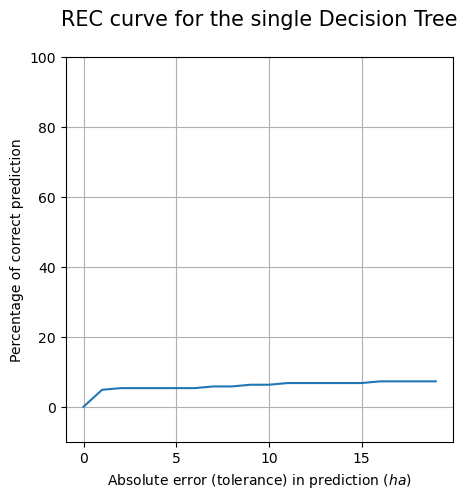

In [62]:
rec_DT=[]
for i in range(tol_max):
    rec_DT.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the single Decision Tree\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_DT)

### Método 3 - Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
param_grid = {'max_depth': [5,10,15,20,50], 'max_leaf_nodes': [2,5,10], 'min_samples_leaf': [2,5,10],
             'min_samples_split':[2,5,10]}
grid_RF = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=0,cv=5)
grid_RF.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 50],
                         'max_leaf_nodes': [2, 5, 10],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [34]:
print("Best parameters obtained by Grid Search:",grid_RF.best_params_)

Best parameters obtained by Grid Search: {'max_depth': 20, 'max_leaf_nodes': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}


In [49]:
a=grid_RF.predict(X_test)
RMSE_RF=np.sqrt(np.mean((y_test-a)**2))
print("RMSE for Random Forest:",RMSE_RF)

RMSE for Random Forest: 0.5967442406216151


In [36]:
#plt.xlabel("Actual area burned")
#plt.ylabel("Error")
#plt.grid(True)
#plt.scatter(10**(y_test),10**(a)-10**(y_test))

In [37]:
#plt.title("Histogram of prediction errors\n",fontsize=18)
#plt.xlabel("Prediction error ($ha$)",fontsize=14)
#plt.grid(True)
#plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

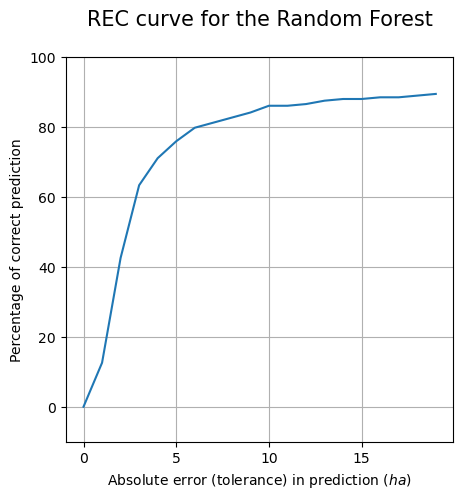

In [38]:
rec_RF=[]
for i in range(tol_max):
    rec_RF.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Random Forest\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_RF)

### Método 4 - Layer Dense Neural Network - Deep network ( Keras (TensorFlow))

In [39]:
from keras.models import Sequential
import keras.optimizers as opti
from keras.layers import Dense, Activation,Dropout

In [40]:
# layers - camadas
model = Sequential()
model.add(Dense(100, input_dim=12))
model.add(Activation('selu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Activation('selu'))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5

In [41]:
# taxa de aprendizado e otimização
learning_rate=0.001
optimizer = opti.RMSprop(lr=learning_rate)
model.compile(optimizer=optimizer,loss='mse')

In [42]:
#### Input data and mode fitting
data=X_train
target = y_train
model.fit(data, target, epochs=100, batch_size=10,verbose=0)

In [43]:
#### Prediction and RMSE
a=model.predict(X_test)
RMSE_LDNN = np.sqrt(np.mean((y_test-a.reshape(a.size,))**2))
#print("RMSE for Deep Network:",np.sqrt(np.mean((y_test-a.reshape(a.size,))**2)))
print("RMSE for Deep Network:",RMSE_LDNN)

7/7 [==============================] - 0s 3ms/step
RMSE for Deep Network: 0.5941897624721414


In [44]:
#plt.xlabel("Actual area burned")
#plt.ylabel("Error")
#plt.grid(True)
#plt.scatter(10**(y_test),10**(a.reshape(a.size,))-10**(y_test))

In [45]:
#plt.title("Histogram of prediction errors\n",fontsize=18)
#plt.xlabel("Prediction error ($ha$)",fontsize=14)
#plt.grid(True)
#plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

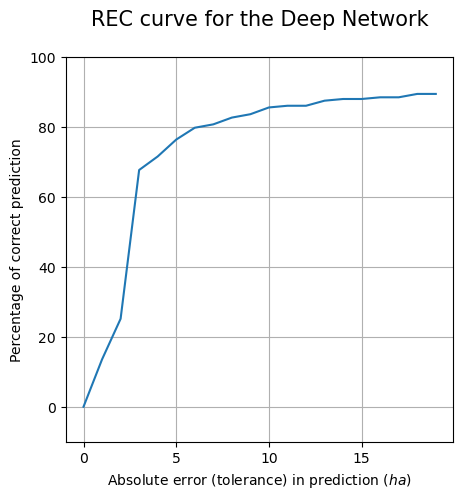

In [46]:
rec_NN=[]
for i in range(tol_max):
    rec_NN.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Deep Network\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_NN)

## Performance relativa dos quatro modelos (curvas REC)

In [64]:
Ranking_ForrestFire = pd.DataFrame()
index_RFF = ['RMSE']
Ranking_ForrestFire  = pd.DataFrame(index=index_RFF)
Ranking_ForrestFire  ['Support Vector Regression'] = RMSE_SVR
Ranking_ForrestFire  ['Decision Tree'] = RMSE_DT
Ranking_ForrestFire  ['Random Forest'] = RMSE_RF
Ranking_ForrestFire  ['Deep Network'] = RMSE_LDNN

,Support Vector Regression,Decision Tree,Random Forest,Deep Network
RMSE,0.644259,1.511053,0.596744,0.59419


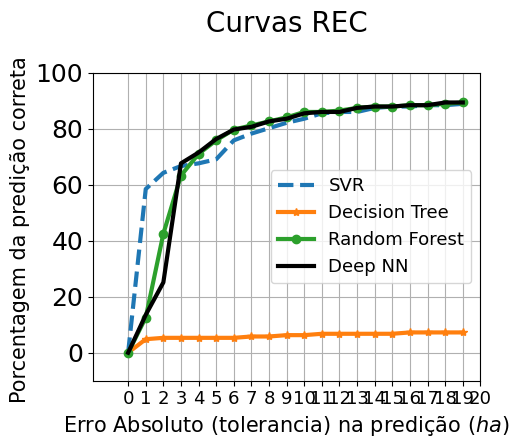

In [65]:
plt.figure(figsize=(5,4))
plt.title("Curvas REC\n",fontsize=20)
plt.xlabel("Erro Absoluto (tolerancia) na predição ($ha$)",fontsize=15)
plt.ylabel("Porcentagem da predição correta ",fontsize=15)
plt.xticks([i for i in range(0,tol_max+1,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,tol_max)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
plt.plot(range(tol_max),rec_SVR,'--',lw=3)
plt.plot(range(tol_max),rec_DT,'*-',lw=3)
plt.plot(range(tol_max),rec_RF,'o-',lw=3)
plt.plot(range(tol_max),rec_NN,'k-',lw=3)
plt.legend(['SVR','Decision Tree','Random Forest','Deep NN'],fontsize=13)
Ranking_ForrestFire 